# A Python tutorial on validating gVirtualXRay:
## Analytic simulation vs. Monte Carlo simulation
### With a realistic beam spectrum and taking into account the energy response of the detector
#### Authors: T. Wen, A. Sujar and F. P. Vidal

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to real images from the [Visible Human Project (VHP)](https://www.nlm.nih.gov/research/visible/visible_human.html). We take into account i) a realistic beam spectrum and ii) the energy response of the detector.

**Material and Methods:** <!--We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).-->

<!-- In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic and the energy response of the detector is considered.
 -->
<!-- ![Geometric parameters](doc/setup.png)
 -->
<!--The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density.--> We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). <!--The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).-->

![Sample composition](plots/VHP_model.png)

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is **MAPE ????%**. The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is ????%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.????**. 
As MAPE is low (close to 0), SSIM is 0.???, and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations ran on supercomputers for days.

## Import packages

In [1]:
%matplotlib inline

import os # Locate files

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tifffile import imread, imsave # Load/Write TIFF files

import viewscad # Use OpenSCAD to create STL files

# import pyvista as pv # 3D visualisation
# from pyvista import themes

# import cma # Optimise the parameters of the noise model

import k3d
import random
import base64
import stl

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up
from utils import * # Code shared across more than one notebook
import cma # Optimisation
import sys

SimpleGVXR 1.0.1 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-11-01T10:36:47) [Compiler: GNU g++] on Linux


In [2]:
def standardisation(img):
    return (img - img.mean()) / img.std()

## Reference image

We first load the reference image from the [Visible Human Project](https://www.nlm.nih.gov/databases/download/vhp.html). You can find it at [https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z](https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Male-Images/radiological/xray8/x_vm_pe.Z). When you download it, make sure to gunzip it!

In [3]:
Image = np.fromfile("VHP/x_vm_pe", dtype=np.uint8)
Image.shape = (1536,1248)
Image = np.rot90(Image)

In [4]:
imsave('gVirtualXRay_output_data/real_projection-VHP.tif', Image.astype(np.single))

In [5]:
raw_reference = Image.astype(np.single) / 255.0

In [6]:
imsave('gVirtualXRay_output_data/corrected_real_projection-VHP.tif', raw_reference.astype(np.single))

We plot the image using a linear look-up table and a power-law normalisation.

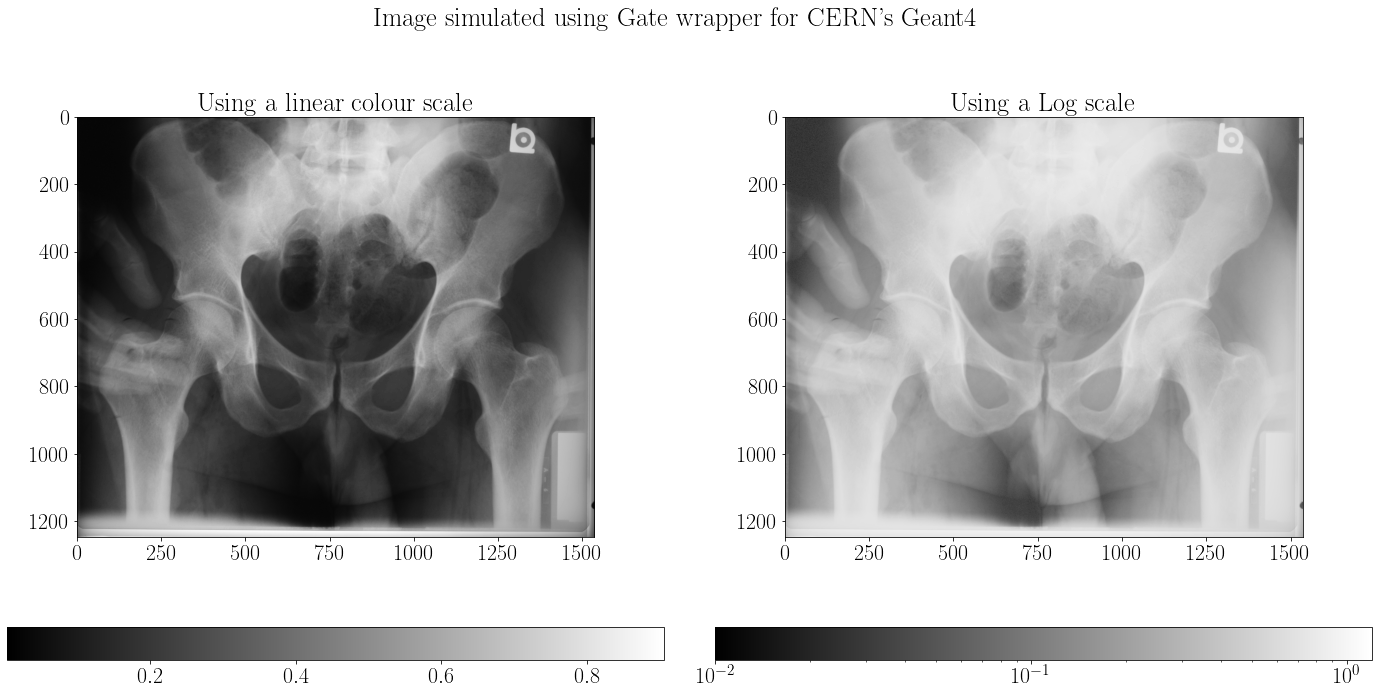

In [7]:
displayLinearPowerScales(raw_reference,
                         "Image simulated using Gate wrapper for CERN's Geant4",
                         "plots/reference_from_Gate-VHP",
                         log=True)

Apply a log transformation

In [30]:
ground_truth = raw_reference
ground_truth = np.log(ground_truth)
ground_truth = standardisation(ground_truth)

imsave('gVirtualXRay_output_data/ground_truth-VHP.tif', ground_truth.astype(np.single))

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [9]:
json2gvxr.initGVXR("notebook-8.json", "OPENGL")

Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## X-ray source

We create an X-ray source. It is a point source.

In [10]:
json2gvxr.initSourceGeometry("notebook-8.json")

Set up the beam
	Source position: [0.0, -16.5, 150.0, 'cm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [11]:
spectrum, unit, k, f = json2gvxr.initSpectrum("notebook-8.json", verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

params["Source"]["Beam"] {'kvp': 85, 'tube angle': 12, 'filter': [['Al', 3.2]]}
['Al', 3.2]


Plot the spectrum

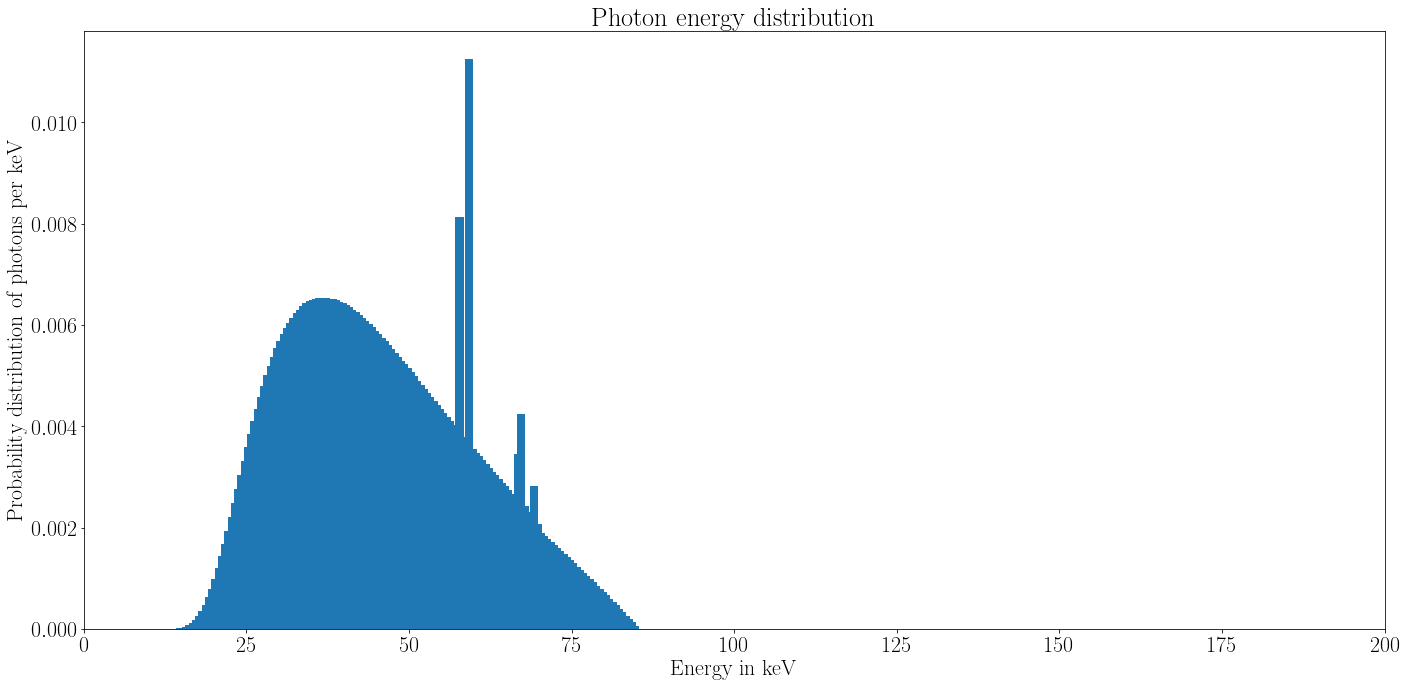

In [12]:
plotSpectrum(k, f, 'plots/spectrum-VHP')

## Detector

Create a digital detector

In [13]:
json2gvxr.initDetector("notebook-8.json")

Set up the detector
	Detector position: [0.0, -16.5, -12.5, 'cm']
	Detector up vector: [0, -1, 0]
	Detector number of pixels: [1536, 1248]
	Energy response: Gate_data/responseDetector.txt in MeV
	Pixel spacing: [0.026347682927083334, 0.026347683, 'cm']
INIT RENDER


## Model the energy response of the detector

Load the energy response

In [14]:
detector_response = np.loadtxt("Gate_data/responseDetector.txt")

Display the energy response

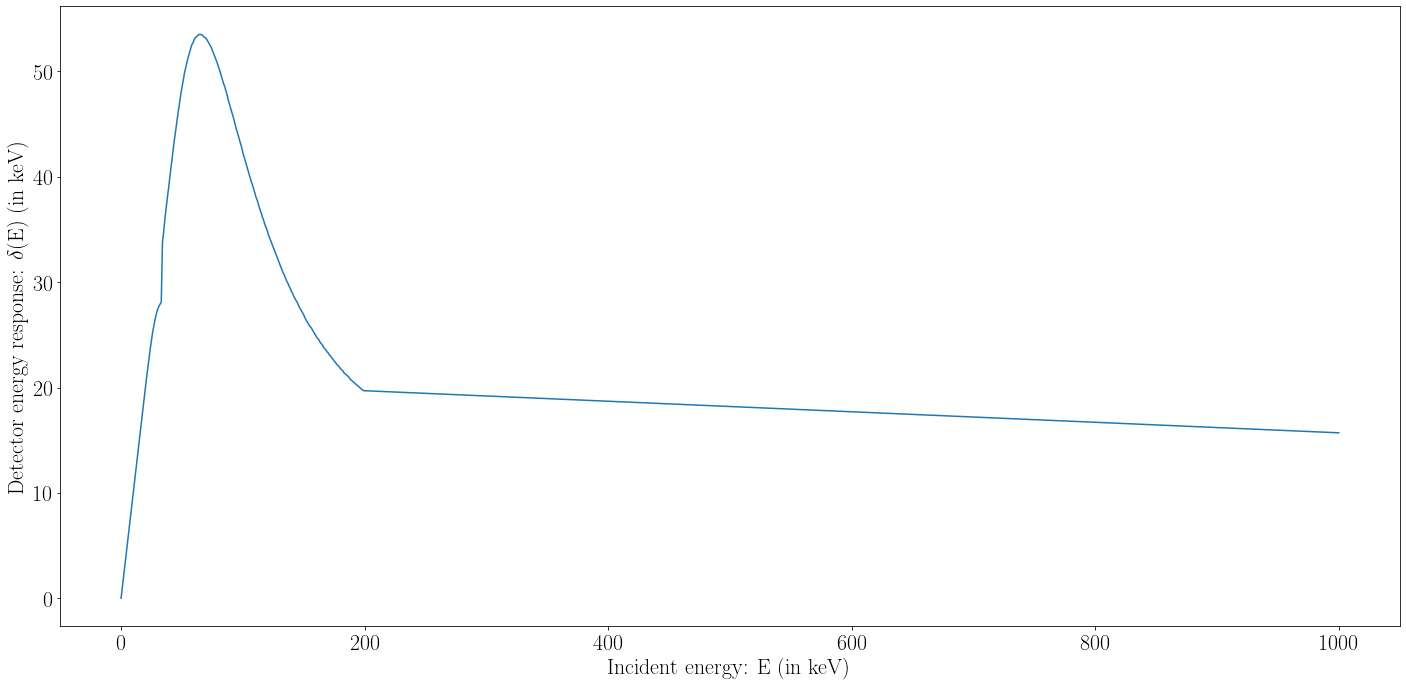

In [15]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

plt.savefig('plots/detector_response-VHP.pdf')
plt.savefig('plots/detector_response-VHP.png')

## Sample

We now load the models segmented from the Visible Human.

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [16]:
json2gvxr.initSamples(verbose=0)

file_name:	VHP/meshes/chest.stl	nb_faces:	89235	nb_vertices:	267705	bounding_box (in cm):	(-5.19216, -2.22134, -4.18652)	(5.28961, 12.0778, 3.51821)
file_name:	VHP/meshes/chest2.stl	nb_faces:	75408	nb_vertices:	226224	bounding_box (in cm):	(-5.20763, -2.213, -4.16399)	(5.26581, 12.0682, 4.06685)
file_name:	VHP/meshes/femurL.stl	nb_faces:	9660	nb_vertices:	28980	bounding_box (in cm):	(2.2332, -14.6571, -1.851)	(5.5281, -8.86371, 0.57499)
file_name:	VHP/meshes/femurR.stl	nb_faces:	9660	nb_vertices:	28980	bounding_box (in cm):	(-5.60176, -14.6576, -1.48193)	(-2.25352, -8.82717, 0.79766)
file_name:	VHP/meshes/hips.stl	nb_faces:	56575	nb_vertices:	169725	bounding_box (in cm):	(-4.86403, -12.1307, -4.17882)	(4.97615, -4.45668, 1.91861)
file_name:	VHP/meshes/bladder.stl	nb_faces:	2706	nb_vertices:	8118	bounding_box (in cm):	(-1.47306, -10.5873, -0.88731)	(0.947542, -9.09488, 1.8016)
file_name:	VHP/meshes/bronch.stl	nb_faces:	1658	nb_vertices:	4974	bounding_box (in cm):	(-1.94132, 5.95348, -1.

# Apply the scaling factor from pixels to cm

In [17]:
for mesh in json2gvxr.params["Samples"]:
    label = mesh["Label"]
    gvxr.scaleNode(label, 3.3, 3.3, 3.3)
    gvxr.applyCurrentLocalTransformation(label)

Visualise the virtual patient

## Registration of the patient, source and detector

The SSD, DOD and rotation of the virtual patient are unknown. We estimate them to register a simulated X-ray image on a real radiograph.

In [18]:
total_energy_in_keV = 0.0
for energy, count in zip(energy_set, count_set):
    effective_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

    total_energy_in_keV += effective_energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [19]:
# Function to update source and detector position
def updateSourceAndDetectorPosition(x, y, SOD, DOD):
        
    # Update source position
    source_position = [x, y, SOD, "cm"]
    gvxr.setSourcePosition(
        source_position[0],
        source_position[1],
        source_position[2],
        source_position[3]
    )

    # Update detector position
    detector_position = [x, y, -DOD, "cm"]
    gvxr.setDetectorPosition(
        detector_position[0],
        detector_position[1],
        detector_position[2],
        detector_position[3]
    )

# function to compute X-Ray image and reset rotation
def computeXRayImageAndResetGeometry(anAngleX, anAngleY):
    
    
    matrix = gvxr.getSceneTransformationMatrix()
    
    gvxr.rotateScene(anAngleX, 1, 0, 0)
    gvxr.rotateScene(anAngleY, 0, 1, 0)
    
    image = np.array(gvxr.computeXRayImage())
    
    gvxr.setSceneTransformationMatrix(matrix)

    return image

In [20]:
# Define objective function
def objectiveFunction(x):
    
    global total_energy_in_MeV
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_zncc, evolution_parameters
    
    SOD = x[0] 
    DOD = x[1]
    rotation_angle_x = x[2]
    rotation_angle_y = x[3]
    
    x_pos = x[4]
    y_pos = x[5]
    
    # set up source and detector position
    updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)
    
    # compute X-Ray image and reset rotation
    x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)

    # Flat-field
    x_ray_image /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
    # x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()
    
    # Brightness/contrast
    # x_ray_image += shift
    # x_ray_image *= scale
    
    
    ## MIRROR THE PICTURE!!!

    
    x_ray_image = standardisation(x_ray_image)
    
    objective = math.sqrt(mean_squared_error(ground_truth, x_ray_image))
    
    # objective = mape(ground_truth, x_ray_image)
    
    if best_fitness > objective:
        
        gvxr.displayScene()
        screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

        imsave("gVirtualXRay_output_data/HIPS_xray_" + str(best_fitness_id) + ".tif", x_ray_image.astype(np.single))
        imsave("gVirtualXRay_output_data/HIPS_screenshot_" + str(best_fitness_id) + ".tif", screenshot)
    
        zncc_value = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image - x_ray_image.mean()) / x_ray_image.std())
        evolution_zncc.append([fitness_function_call_id, zncc_value])
        evolution_parameters.append([fitness_function_call_id, SOD, DOD, rotation_angle_x, rotation_angle_y,x_pos, y_pos])
        
        best_fitness = objective
        best_fitness_id += 1
    
    fitness_function_call_id += 1
   
    return objective

Compute the SOD and DOD

In [21]:
source_position = gvxr.getSourcePosition("cm")
detector_position = gvxr.getDetectorPosition("cm")

source_accumulator = 0.0
detector_accumulator = 0.0

for i, j in zip(source_position, detector_position):
    if i != j:
        source_accumulator += i * i
        detector_accumulator += j * j

SOD = math.sqrt(source_accumulator)

DOD = math.sqrt(detector_accumulator)

print("SOD:", SOD)
print("DOD:", DOD)

SOD: 150.0
DOD: 12.5


In [28]:
SOD = 150.0
DOD = 12.5

x_init = [SOD, 40, 0, 0, 0, -35]

SOD = x_init[0] 
DOD = x_init[1]
rotation_angle_x = x_init[2]
rotation_angle_y = x_init[3]

x_pos = x_init[4]
y_pos = x_init[5]

# set up source and detector position
updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

# compute X-Ray image and reset rotation
x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
imsave('gVirtualXRay_output_data/temp.tif', x_ray_image.astype(np.single))

# Flat-field
x_ray_image /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
x_ray_image = np.ones(x_ray_image.shape) - x_ray_image

x_ray_image = standardisation(x_ray_image)

imsave('gVirtualXRay_output_data/x_ray_image-VHP.tif', x_ray_image.astype(np.single))

In [23]:
gvxr.displayScene()
gvxr.setZoom(1834.34326171875)
gvxr.setSceneRotationMatrix([
        0.7077475786209106,   -0.021133223548531532, -0.7061462998390198,  0.0,
       -0.0030647937674075365, 0.9994487762451172,   -0.03298407047986984, 0.0,
        0.7064606547355652,    0.025507455691695213,  0.7072934508323669,  0.0,
        0.0,                   0.0,                   0.0,                 1.0
    ])

gvxr.enableArtefactFilteringOnGPU()
gvxr.useNegative()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()

gvxr.displayScene()

0 0 500 500
0 0 800 450


In [26]:
gvxr.renderLoop()
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

0 0 1920 1016


In [ ]:
# if os.path.exists("gVirtualXRay_output_data/HIPS_evolution_parameters.dat"):
#     SOD, DOD, rotation_angle_x, rotation_angle_y,x_pos, y_pos = np.loadtxt("gVirtualXRay_output_data/HIPS.dat")
#     evolution_zncc = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat")
#     evolution_parameters = np.loadtxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat")

# # CMA-ES
# else:


opts = cma.CMAOptions()
opts.set('tolfun', 1e-6)
opts['tolx'] = 1e-2
opts['bounds'] = [[SOD * 0.7, 35, -2., -2., -2., -50],
                  [SOD * 1.3, 100, 2.,  2.,  2.,  50]]

opts['CMA_stds'] = []

rotation_angle_x = 0.0
rotation_angle_y = 0.0

# shift = 0.0
# scale = 1.0
# -5.0, 0.0
# 5.0, 5.0

for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
    opts['CMA_stds'].append(abs(max_val - min_val) * 0.05)

best_fitness = sys.float_info.max
best_fitness_id = 0
fitness_function_call_id = 0
evolution_zncc = []
evolution_parameters = []

res = cma.fmin(objectiveFunction,
          x_init,
          0.5,
          opts,
          restarts=0)
SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos = res[0]


# Save best parameters from the optimiser
np.savetxt("gVirtualXRay_output_data/HIPS.dat", [SOD, DOD, rotation_angle_x, rotation_angle_y, x_pos, y_pos], header='SOD,DOD,rotation_angle_x,rotation_angle_y,x_pos,y_pos')

# Save the list of zncc for plotting
evolution_zncc = np.array(evolution_zncc)
np.savetxt("gVirtualXRay_output_data/HIPS_evolution_zncc.dat", evolution_zncc, header='t,ZNCC')

# Save the list of parameters for plotting
evolution_parameters = np.array(evolution_parameters)
np.savetxt("gVirtualXRay_output_data/HIPS_evolution_parameters.dat", evolution_parameters, header='t,SOD,DOD,rotation_angle_x,rotation_angle_y,x_pos,y_pos')

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=407936, Tue Nov 30 17:02:50 2021)


## Registration for image processing (shift and scale)
Optimising image brightness/contrast

In [ ]:
# set up source and detector position
updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

gvxr.rotateScene(rotation_angle_x, 1, 0, 0)
gvxr.rotateScene(rotation_angle_y, 0, 1, 0)

x_ray_image = np.array(gvxr.computeXRayImage())

In [ ]:
def objectiveFunctionImageProcessing(x):
    
    global total_energy_in_MeV, x_ray_image

    shift = x[0]
    scale = x[1]
    
    x_ray_image = np.array(gvxr.computeXRayImage())
    
    # Flat-field
    x_ray_image /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    x_ray_image = np.ones(x_ray_image.shape) - x_ray_image
    # x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()
    
    # Brightness/contrast
    x_ray_image += shift
    x_ray_image *= scale
    
    ## MIRROR THE PICTURE!!!
    
    # objective = mape(ground_truth, x_ray_image)

    x_ray_image = standardisation(x_ray_image)

    objective = math.sqrt(mean_squared_error(ground_truth, x_ray_image))
    
    return objective

In [ ]:

opts = cma.CMAOptions()
opts.set('tolfun', 1e-6)
opts['tolx'] = 1e-2
opts['bounds'] = [[-1.0, 0.0],
                  [1.0, 1.0]]

opts['CMA_stds'] = []

shift = 0.0
scale = 1.0

for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
    opts['CMA_stds'].append(abs(max_val - min_val) * 0.05)

best_fitness = sys.float_info.max
best_fitness_id = 0
fitness_function_call_id = 0
evolution_zncc = []
evolution_parameters = []

res = cma.fmin(objectiveFunctionImageProcessing,
          [shift, scale],
          0.5,
          opts,
          restarts=0)
shift, scale = res[0]


In [32]:
print("SOD (cm):", SOD)
print("DOD (cm):", DOD)
print("Rotation angle x:", rotation_angle_x)
print("Rotation angle y:", rotation_angle_y)
print("Shift:", shift)
print("Scale:", scale)
print("x_pos:", x_pos)
print("y_pos:", y_pos)

SOD (cm): 194.99998179437932
DOD (cm): 35.00000160427536
Rotation angle x: 1.9999998150338267
Rotation angle y: 1.9999780714705842
Shift: -4.99999995604546
Scale: 0.32785544847441306
x_pos: 1.999998283281222
y_pos: -34.99999993693885


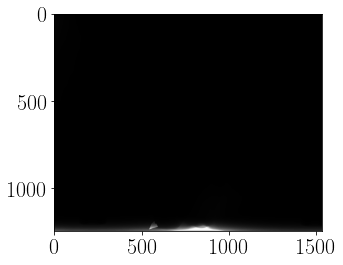

In [36]:
# # set up source and detector position
# updateSourceAndDetectorPosition(x_pos, y_pos, SOD, DOD)

# # compute X-Ray image and reset rotation
# x_ray_image = computeXRayImageAndResetGeometry(rotation_angle_x, rotation_angle_y)
gvxr.displayScene()

x_ray_image = np.array(gvxr.computeXRayImage())
# x_ray_image = (x_ray_image - x_ray_image.mean()) / x_ray_image.std()

x_ray_image += shift
x_ray_image *= scale

plt.imshow(x_ray_image, cmap='gray')

In [ ]:
# source_position = gvxr.getSourcePosition("cm")
# detector_position = gvxr.getDetectorPosition("cm")

# print(source_position)
# print(detector_position)

In [ ]:
# updateSourceAndDetectorPosition(0, -5, 50.0, 112.5)

In [ ]:
# gvxr.renderLoop()

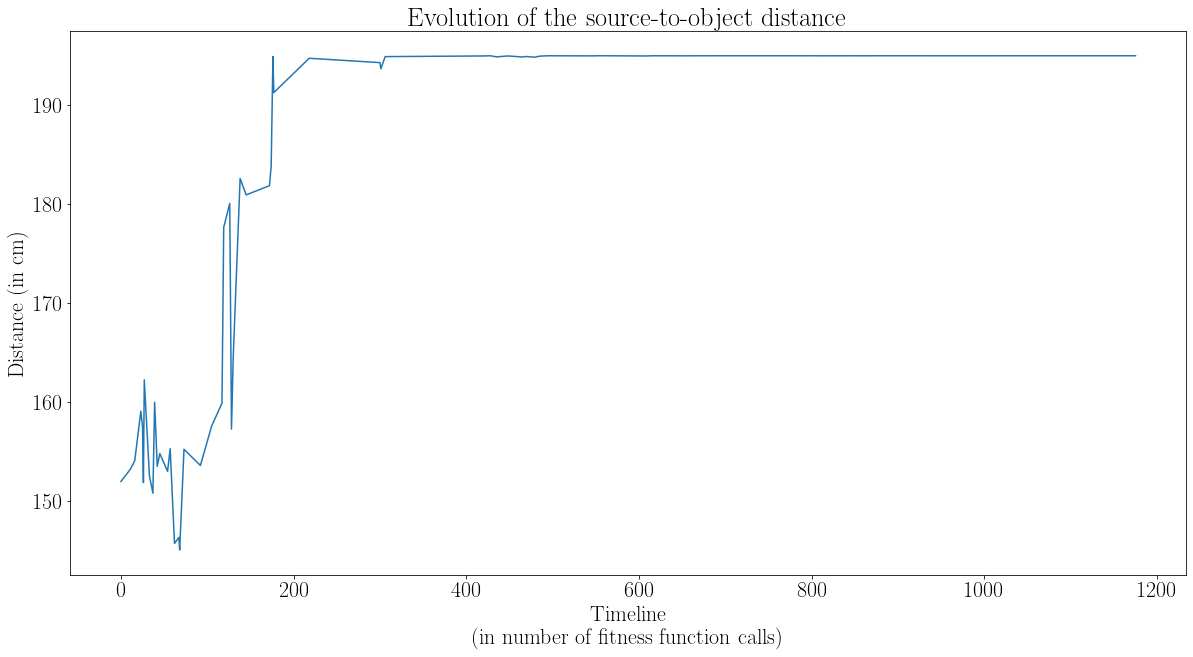

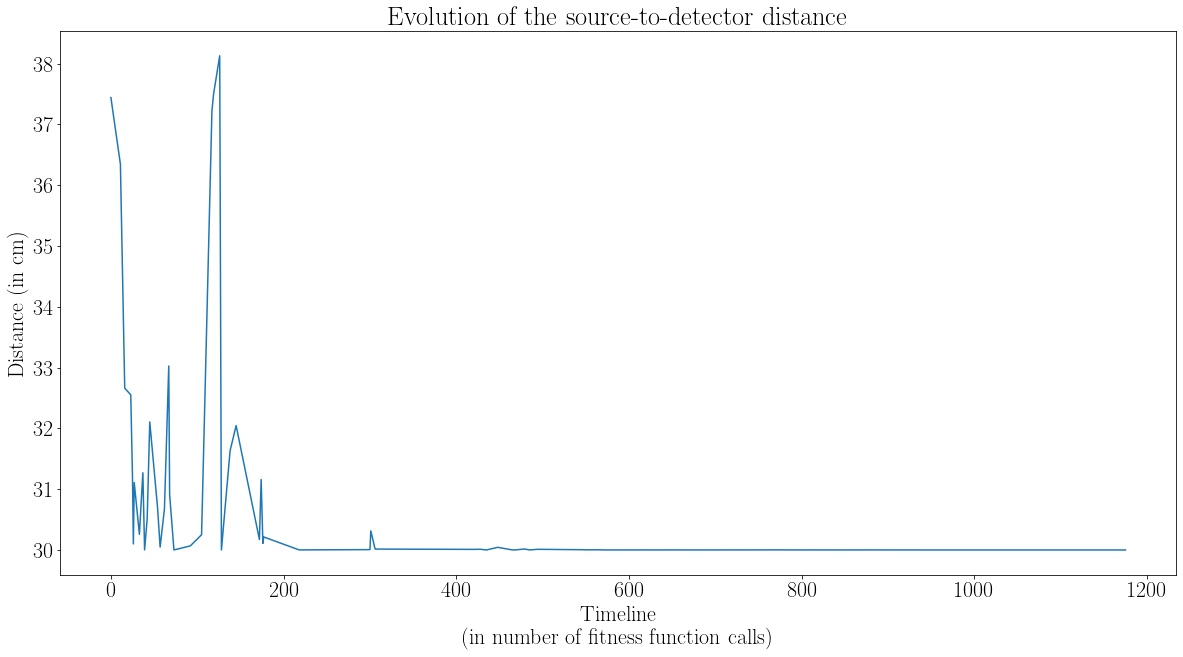

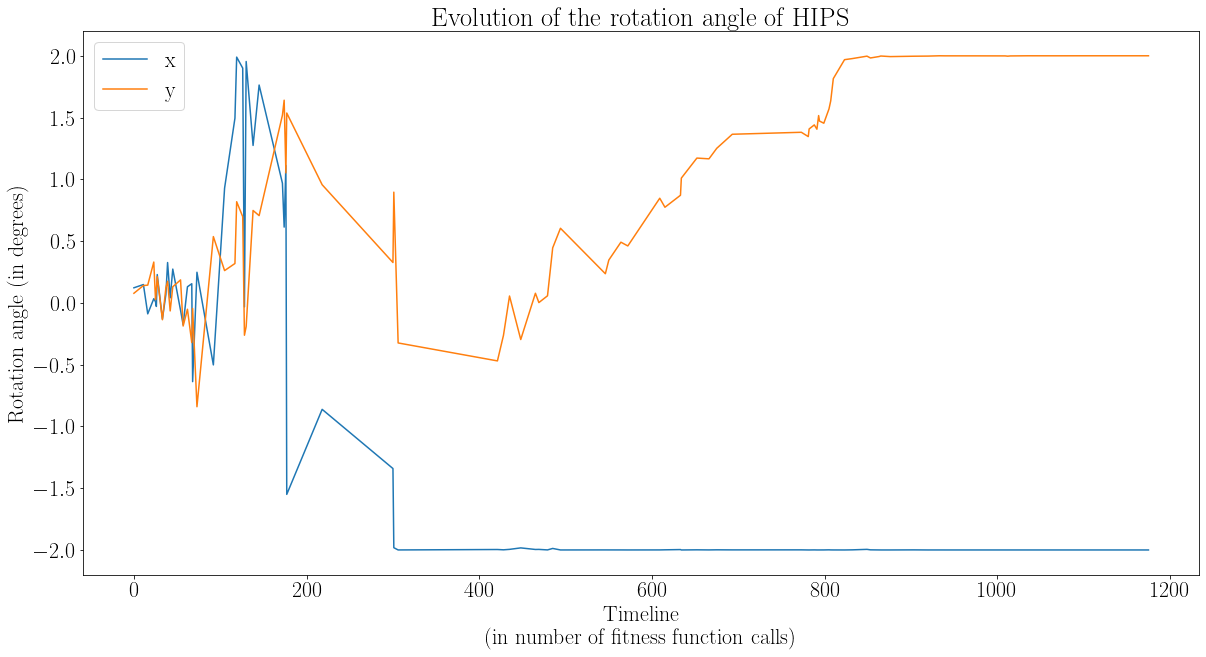

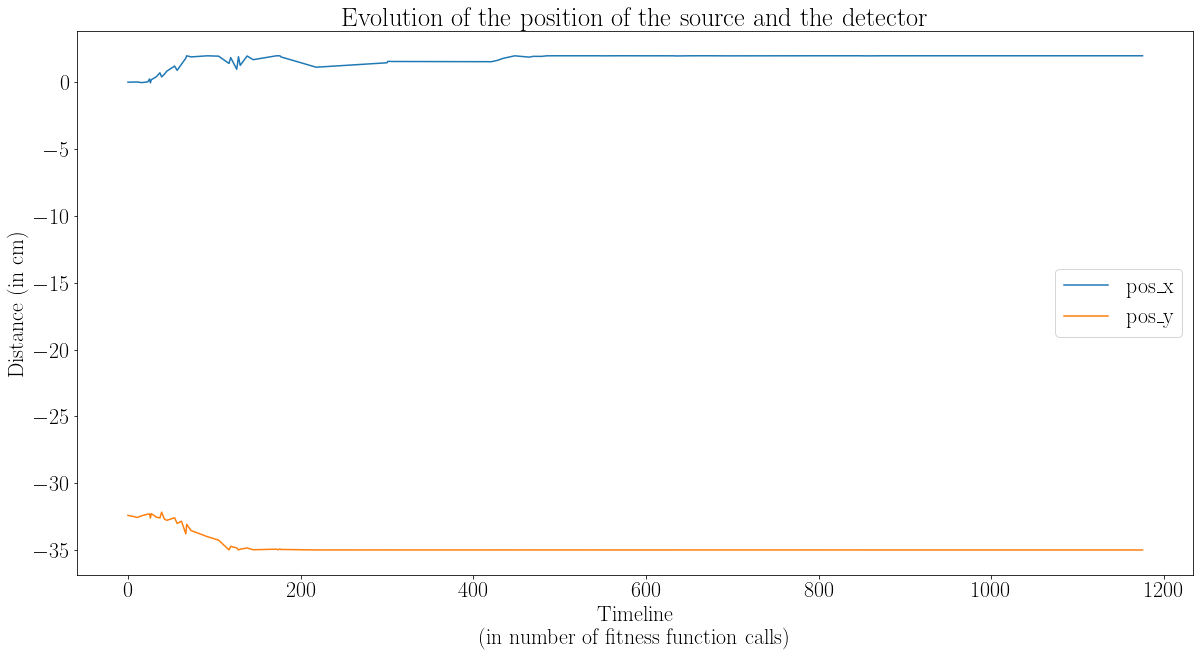

In [32]:
evolution_parameters = np.array(evolution_parameters)

plt.figure(figsize= (20,10))
plt.title("Evolution of the source-to-object distance")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,1])
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in cm)")
plt.savefig('plots/HIPS_evolution_SOD.pdf')
plt.savefig('plots/HIPS_volution_SOD.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the source-to-detector distance")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,2])
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in cm)")
plt.savefig('plots/HIPS_evolution_DOD.pdf')
plt.savefig('plots/HIPS_volution_DOD.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the rotation angle of HIPS")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,3], label="x")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,4], label="y")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Rotation angle (in degrees)")
plt.legend()
plt.savefig('plots/HIPS_evolution_angles.pdf')
plt.savefig('plots/HIPS_evolution_angles.png')

plt.figure(figsize= (20,10))
plt.title("Evolution of the position of the source and the detector")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,5], label="pos_x")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,6], label="pos_y")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Distance (in cm)")
plt.legend()
plt.savefig('plots/HIPS_evolution_pos.pdf')
plt.savefig('plots/HIPS_evolution_pos.png')

# plt.figure(figsize= (20,10))
# plt.title("Evolution of image shift")
# plt.plot(evolution_parameters[:,0], evolution_parameters[:,5])
# plt.xlabel("Timeline\n(in number of fitness function calls)")
# plt.ylabel("shift")
# plt.savefig('plots/HIPS_evolution_shift.pdf')
# plt.savefig('plots/HIPS_evolution_shift.png')

# plt.figure(figsize= (20,10))
# plt.title("Evolution of image scale")
# plt.plot(evolution_parameters[:,0], evolution_parameters[:,6])
# plt.xlabel("Timeline\n(in number of fitness function calls)")
# plt.ylabel("scale")
# plt.savefig('plots/HIPS_evolution_scale.pdf')
# plt.savefig('plots/HIPS_evolution_scale.png')

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [ ]:
gvxr.displayScene()
gvxr.enableArtefactFilteringOnGPU()
gvxr.computeXRayImage()

gvxr.useLighing()
gvxr.useWireframe()
# gvxr.setZoom(419.6787109375)
# gvxr.setSceneRotationMatrix([ 0.46270546317100525, -0.04590693116188049, -0.8853222727775574,  0.0,
#                              -0.0284021757543087,   0.9973739981651306,  -0.06656108051538467, 0.0,
#                               0.8860555291175842,   0.055943090468645096, 0.46018826961517334, 0.0,
#                               0.0,                  0.0,                  0.0,                 1.0])

gvxr.useNegative()
gvxr.displayScene()

In [ ]:
screenshot = gvxr.takeScreenshot()

In [ ]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-VHP.pdf')
plt.savefig('plots/screenshot-beam-off-VHP.png')

Compute an X-ray image

In [ ]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

In [ ]:
# Compute the L-buffers on the GPU and integrate on the CPU
# x_ray_image_integration_CPU = computeXRayImageFromLBuffers(json2gvxr, True, detector_response)

# Compute the L-buffers on the GPU and integrate on the GPU
x_ray_image_integration_GPU = np.array(gvxr.computeXRayImage())


# Flat-field
# x_ray_image_integration_CPU /= total_energy_in_MeV
x_ray_image_integration_GPU /= total_energy_in_MeV

# Negative
# x_ray_image = 1.0 - x_ray_image
# x_ray_image_integration_CPU = np.ones(x_ray_image_integration_CPU.shape) - x_ray_image_integration_CPU
x_ray_image_integration_GPU = np.ones(x_ray_image_integration_GPU.shape) - x_ray_image_integration_GPU

# Brightness/contrast
# x_ray_image_integration_CPU += shift
x_ray_image_integration_GPU += shift

# x_ray_image_integration_CPU *= scale
x_ray_image_integration_GPU *= scale

# imsave('gVirtualXRay_output_data/projection_raw_integration_CPU-VHP.tif', x_ray_image_integration_CPU.astype(np.single))
imsave('gVirtualXRay_output_data/projection_raw_integration_GPU-VHP.tif', x_ray_image_integration_GPU.astype(np.single))

Normalise the data

In [ ]:
ground_truth = standardisation(ground_truth)
# x_ray_image_integration_CPU = standardisation(x_ray_image_integration_CPU)
x_ray_image_integration_GPU = standardisation(x_ray_image_integration_GPU)

In [ ]:
print(ground_truth.mean(), ground_truth.std())
# print(x_ray_image_integration_CPU.mean(), x_ray_image_integration_CPU.std())
print(x_ray_image_integration_GPU.mean(), x_ray_image_integration_GPU.std())

Flip the image

Save the corresponding image

In [ ]:
# imsave('gVirtualXRay_output_data/projection_corrected_integration_CPU-VHP.tif', x_ray_image_integration_CPU.astype(np.single))
imsave('gVirtualXRay_output_data/projection_corrected_integration_GPU-VHP.tif', x_ray_image_integration_GPU.astype(np.single))

In [ ]:
# displayLinearPowerScales(x_ray_image_integration_CPU,
#                          "Image simulated using gVirtualXRay,\nintegration on CPU",
#                          'plots/x_ray_image_integration_CPU-VHP')

In [ ]:
displayLinearPowerScales(x_ray_image_integration_GPU,
                         "Image simulated using gVirtualXRay,\nintegration on GPU",
                         'plots/x_ray_image_integration_GPU-VHP')

Compare the manual implementation with gvxr's

In [ ]:
# compareImages(x_ray_image_integration_CPU, ground_truth,
#               "gVirtualXRay with integration on CPU vs Gate\n(checkerboard comparison)",
#               'plots/comparison_integration_CPU-VHP')

compareImages(x_ray_image_integration_GPU, ground_truth,
              "gVirtualXRay with integration on GPU vs Gate\n(checkerboard comparison)",
              'plots/comparison_integration_GPU-VHP')

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD),
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)), and
3. [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity). 


We use these three metrics as one is a disimilarity measurement (MAPE), two are similarity measurement (ZNCC & SSIM). MAPE and ZNCC can be expressed as a percentage, which eases the interpretation of the numerical values. SSIM is a number between 0 and 1. A good value of MAPE s 0%; of ZNCC 100%, and SSIM 1.

In [ ]:
# MAPE_integration_CPU = mape(ground_truth, x_ray_image_integration_CPU)
# ZNCC_integration_CPU = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image_integration_CPU - x_ray_image_integration_CPU.mean()) / x_ray_image_integration_CPU.std())
# SSIM_integration_CPU = ssim(ground_truth, x_ray_image_integration_CPU, data_range=ground_truth.max() - ground_truth.min())


# print("MAPE_integration_CPU:", "{0:0.2f}".format(100 * MAPE_integration_CPU) + "%")
# print("ZNCC_integration_CPU:", "{0:0.2f}".format(100 * ZNCC_integration_CPU) + "%")
# print("SSIM_integration_CPU:", "{0:0.2f}".format(SSIM_integration_CPU))

MAPE_integration_GPU = mape(ground_truth, x_ray_image_integration_GPU)
ZNCC_integration_GPU = np.mean((ground_truth - ground_truth.mean()) / ground_truth.std() * (x_ray_image_integration_GPU - x_ray_image_integration_GPU.mean()) / x_ray_image_integration_GPU.std())
SSIM_integration_GPU = ssim(ground_truth, x_ray_image_integration_GPU, data_range=ground_truth.max() - ground_truth.min())

print("MAPE_integration_GPU:", "{0:0.2f}".format(100 * MAPE_integration_GPU) + "%")
print("ZNCC_integration_GPU:", "{0:0.2f}".format(100 * ZNCC_integration_GPU) + "%")
print("SSIM_integration_GPU:", "{0:0.2f}".format(SSIM_integration_GPU))

In both cases, MAPE is very small (less than 1%) and ZNCC is very high (more than 99%). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

### Qualitative validation

Checkboard comparison

In [ ]:
# fullCompareImages(ground_truth,
#                   x_ray_image_integration_CPU,
#                   "gVirtualXRay\n with integration on CPU",
#                   "plots/full_comparison_integration_CPU-VHP")

fullCompareImages(ground_truth,
                  x_ray_image_integration_GPU,
                  "gVirtualXRay\n with integration on GPU",
                  "plots/full_comparison_integration_GPU-VHP")

In [ ]:
font = {'size'   : 12
       }
matplotlib.rc('font', **font)

Plot the profiles

In [ ]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

In [ ]:
# plotProfiles(json2gvxr, ground_truth, x_ray_image_integration_CPU, x_ray_image_integration_GPU, "plots/profiles-checkerboard-VHP")

In [ ]:
# spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]
# min_limit = round(40)
# max_limit = round(512 * spacing - 40)
# plotProfiles(json2gvxr, ground_truth, x_ray_image_integration_CPU, x_ray_image_integration_GPU, "plots/profiles-zoom-checkerboard-VHP", [min_limit, max_limit])

## All done

Destroy the window

In [ ]:
# gvxr.destroyAllWindows()